In [ ]:
!pip install caer --quiet
!pip install keras-tuner --quiet
!pip -q install streamlit
!pip -q install pyngrok
!pip install ipykernel>=5.1.2
!pip install pydeck

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import cv2
import caer
from  matplotlib import pyplot as plt
from keras_tuner import *
from sklearn.metrics import confusion_matrix,classification_report
from keras_tuner.applications import HyperResNet,HyperXception
from sklearn.utils import shuffle
import streamlit as st
import dlib
from imutils import face_utils
from keras_tuner import HyperParameters

ContextualVersionConflict: ignored

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Found GPU at: /device:GPU:0


2021-10-04 13:48:26.770802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 13:48:27.203943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 13:48:27.204839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 13:48:32.511681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 13:48:32.512577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6797533360000045
GPU (s):
0.04484932899998739
GPU speedup over CPU: 82x


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
IMG_SIZE = (80,80)
char_path = "/content/drive/MyDrive/simpsons_characters_dataset/simpsons_dataset"
char_dict = {}
for char in os.listdir(char_path):
  char_dict[char] = len(os.listdir(os.path.join(char_path,char)))
char_dict = caer.sort_dict(char_dict, descending=True)
characters = []
count = 0
for item in char_dict:
  characters.append(item[0])
  count += 1
  if count >= 10:
      break

In [ ]:
def create_dataset(img_folder,characters):
  img_data_array=[]
  class_name=[]
  for person in os.listdir(img_folder):
    if person in characters:
      for image in os.listdir(os.path.join(img_folder, person)):   
        image_path= os.path.join(img_folder, person,  image)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, IMG_SIZE,interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
        class_name.append(person)
  return img_data_array, class_name
img_data,class_name = create_dataset("/content/drive/MyDrive/simpsons_characters_dataset/simpsons_dataset",characters=characters)

In [ ]:
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

In [ ]:
#On met en place une fonction chargée de créer le modèle
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int("filters_1",32,128,step=32,default=96), 
                            kernel_size=(3, 3), 
                            activation='relu', 
                            input_shape=(80, 80, 3))) 
    model.add(layers.MaxPooling2D((2, 2))) 
    model.add(layers.Conv2D(hp.Int("filters_2",64,256,step=64,default=192), 
                            kernel_size = (3, 3), 
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int("filters_3",64,256,step=64,default=256), 
                            kernel_size = (3, 3), 
                            activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int("units",64,128,step=32,default=128),
                            activation='relu'))
    model.add(layers.Dense(10,activation="softmax"))
    model.compile(
    optimizer = "rmsprop",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["sparse_categorical_accuracy"],
    )
    return model

tuner = RandomSearch(
        build_model,
        objective = "val_sparse_categorical_accuracy",
        max_trials = 5,
        executions_per_trial = 1,
        overwrite = True,
        directory = "my_dir",
        project_name = "hello_world",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
filters_1 (Int)
{'default': 96, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
filters_2 (Int)
{'default': 192, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': None}
filters_3 (Int)
{'default': 256, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}


In [ ]:
x = np.array(img_data,dtype="float32")
y = np.array(list(map(int,target_val)),np.float32)
train_data,train_labels = shuffle(x,y,random_state=0)
x_train = train_data[:11049]
y_train = train_labels[:11049]
x_val =  train_data[11049:]
y_val = train_labels[11049:]
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
train_datagen = ImageDataGenerator(
            rotation_range = 10,
            width_shift_range = .1,
            height_shift_range = .1,
            shear_range = 0.3,
            zoom_range = 0.3,
            horizontal_flip = True,
            fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator()
train_set = train_datagen.flow(x_train,y_train,batch_size=32)
val_set = val_datagen.flow(x_val,y_val,batch_size=32)

In [ ]:
tuner.search(
    train_set,
    validation_data=val_set,
    epochs=5,
    callbacks=[keras.callbacks.TensorBoard("/tmp/logs_dir")]
)

Trial 5 Complete [00h 02m 16s]
val_sparse_categorical_accuracy: 0.853005051612854

Best val_sparse_categorical_accuracy So Far: 0.8696596622467041
Total elapsed time: 00h 12m 19s
INFO:tensorflow:Oracle triggered exit


2021-10-04 14:57:52.615 INFO    tensorflow: Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=1)
model = models[0]
history = model.fit_generator(train_set,
                              validation_data = val_set,
                              verbose=2,
                              epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
346/346 - 23s - loss: 0.5175 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.8621
Epoch 2/5
346/346 - 22s - loss: 0.4691 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.5746 - val_sparse_categorical_accuracy: 0.8436
Epoch 3/5
346/346 - 22s - loss: 0.4402 - sparse_categorical_accuracy: 0.8688 - val_loss: 0.3438 - val_sparse_categorical_accuracy: 0.9030
Epoch 4/5
346/346 - 22s - loss: 0.4127 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.2736 - val_sparse_categorical_accuracy: 0.9229
Epoch 5/5
346/346 - 22s - loss: 0.4200 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9146


In [ ]:
model.save(r"C:/Users/Massamba Sene/Deep_learning/model.h5")

In [ ]:
loaded_model = tf.keras.models.load_model(r"C:/Users/Massamba Sene/Deep_learning/model.h5")

In [ ]:
x_test,y_test = create_dataset("/content/drive/MyDrive/simpsons_characters_dataset/kaggle_simpson_testset/kaggle_simpson_testset",
                               characters=characters)
target_dict = {k: v for v, k in enumerate(np.unique(y_test))}
target_val = [target_dict[y_test[i]] for i in range(len(y_test))]
x_test = np.array(x_test,np.float32)
y_test = np.array(list(map(int,target_val)),np.float32)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)

16/16 - 1s - loss: 0.1587 - sparse_categorical_accuracy: 0.9375
0.9375


In [ ]:
def print_confusion_matrix(confusion_matrix,class_names,figsize=(10,7),fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix,index=class_names,columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm,annot=True,fmt='d')
    except ValueError:
        raise ValueError("Confusion matrix must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right",fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right",fontsize=fontsize)
    plt.ylabel("Truth")
    plt.xlabel("Prediction")

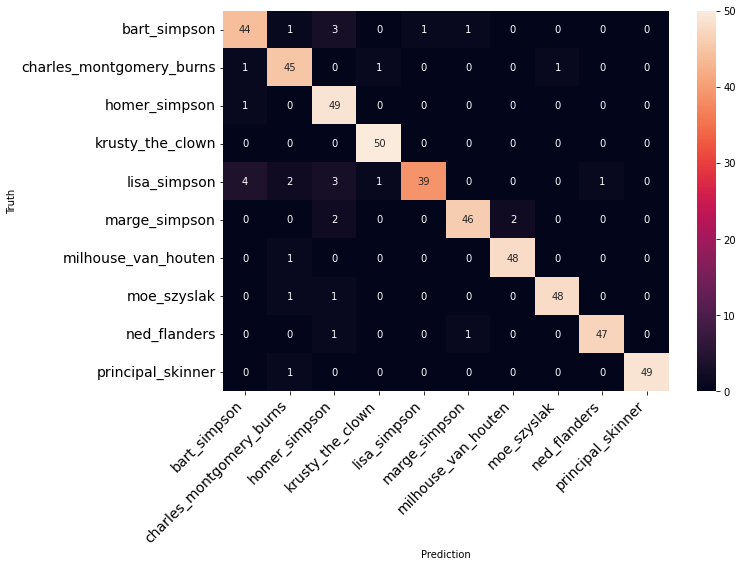

In [ ]:
predictions = model.predict(x_test)
prediction_labels = np.argmax(predictions,1)
cm = confusion_matrix(y_test,prediction_labels)
print_confusion_matrix(cm,class_names=['bart_simpson','charles_montgomery_burns', 'homer_simpson','krusty_the_clown',
                                     'lisa_simpson','marge_simpson','milhouse_van_houten','moe_szyslak','ned_flanders',
                                       'principal_skinner'])

In [ ]:
print(classification_report(y_test,prediction_labels))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        50
         1.0       0.88      0.94      0.91        48
         2.0       0.83      0.98      0.90        50
         3.0       0.96      1.00      0.98        50
         4.0       0.97      0.78      0.87        50
         5.0       0.96      0.92      0.94        50
         6.0       0.96      0.98      0.97        49
         7.0       0.98      0.96      0.97        50
         8.0       0.98      0.96      0.97        49
         9.0       1.00      0.98      0.99        50

    accuracy                           0.94       496
   macro avg       0.94      0.94      0.94       496
weighted avg       0.94      0.94      0.94       496



In [ ]:
model.save(r"/content/drive/MyDrive/model.h5")